In [35]:
from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS
import os
import folium
from matplotlib import pyplot as plt

# Debug section used while testing

Functions for debugging

In [36]:
def print_metadata(image_path):
    print(f"\nExtracting metadata from {image_path}\n")
    image = Image.open(image_path)
    metadata = image._getexif()
    if metadata:
        for tag_id, value in metadata.items():
            tag_name = TAGS.get(tag_id, tag_id)
            print(f"{tag_name}: {value}")
    else:
        print("No EXIF metadata found.")

def print_gps_info(image_path):
    print(f"\nExtracting GPS info from {image_path}\n")
    image = Image.open(image_path)
    exif_data = image._getexif()
    if exif_data:
        for tag_id in exif_data:
            tag_name = TAGS.get(tag_id, tag_id)
            if tag_name == "GPSInfo":
                gps_data = exif_data[tag_id]
                for gps_tag in gps_data:
                    gps_tag_name = GPSTAGS.get(gps_tag, gps_tag)
                    print(f"{gps_tag_name}: {gps_data[gps_tag]}")
    else:
        print("No EXIF metadata found.")

Print metadata

In [37]:
cwd = os.getcwd()

folder = os.path.join(cwd, "Rhea")
folders = os.listdir(folder)
print(folders)
folders = [os.path.join(folder, f) for f in folders if os.path.isdir(os.path.join(folder, f))]
print(folders)
folder = folders[0]
files = os.listdir(folder)
print(files)
for file in files:
    if file.endswith(".JPG") or file.endswith(".jpg"):
        print_metadata(os.path.join(folder, file))
        print_gps_info(os.path.join(folder, file))
        print()

['General', 'Organic', 'Recycling']
['d:\\Uni\\Year 3\\CV\\Assignment\\Rhea\\General', 'd:\\Uni\\Year 3\\CV\\Assignment\\Rhea\\Organic', 'd:\\Uni\\Year 3\\CV\\Assignment\\Rhea\\Recycling']
['PXL_20241103_204050344.jpg', 'PXL_20241103_204055526.NIGHT.jpg', 'PXL_20241103_204101285.NIGHT.jpg', 'PXL_20241103_204557925.NIGHT.jpg', 'PXL_20241103_204700903.NIGHT.jpg', 'PXL_20241103_204754446.NIGHT.jpg', 'PXL_20241103_204802890.NIGHT.jpg', 'PXL_20241103_204807416.NIGHT.jpg', 'PXL_20241103_204859484.NIGHT.jpg', 'PXL_20241103_204907919.NIGHT.jpg', 'PXL_20241111_080954004.jpg', 'PXL_20241125_064354784.MP.jpg', 'PXL_20241226_075623823.jpg', 'PXL_20241226_075822416.jpg', 'PXL_20241226_080206573.jpg', 'PXL_20241226_080604028.MP.jpg']

Extracting metadata from d:\Uni\Year 3\CV\Assignment\Rhea\General\PXL_20241103_204050344.jpg

GPSInfo: {0: b'\x02\x02\x00\x00', 1: 'N', 2: (35.0, 53.0, 53.13), 3: 'E', 4: (14.0, 30.0, 44.47), 5: b'\x00', 6: 81.3, 7: (20.0, 40.0, 44.0), 16: 'M', 17: 177.0, 29: '2024:11:

# Image Directories

In [38]:
cwd = os.getcwd()
folders = os.listdir(cwd)
folders = [os.path.join(cwd, folder) for folder in folders if os.path.isdir(os.path.join(cwd, folder))]

# Image Metadata

### Helper Functions

In [39]:
def get_geotags(image_path):
    image = Image.open(image_path)
    metadata = image._getexif()
    if not metadata:
        return None
    
    geotags = {}

    for tag_id in metadata:
        tag_name = TAGS.get(tag_id, tag_id)
        if tag_name == "GPSInfo":
            gps_data = metadata[tag_id]
            for gps_tag in gps_data:
                geotags[GPSTAGS.get(gps_tag, gps_tag)] = gps_data[gps_tag]
    return geotags

def convert_to_degrees(value):
    d, m, s = value
    return d + (m / 60.0) + (s / 3600.0)

def get_coordinates(geotags):
    lat = convert_to_degrees(geotags["GPSLatitude"])
    if geotags["GPSLatitudeRef"] == "S":
        lat = -lat

    lon = convert_to_degrees(geotags["GPSLongitude"])
    if geotags["GPSLongitudeRef"] == "W":
        lon = -lon

    return lat, lon

def find_center(coordinates):
    # Find the center of a set of coordinates
    lats = [coord[0] for coord in coordinates]
    lons = [coord[1] for coord in coordinates]
    return sum(lats) / len(coordinates), sum(lons) / len(coordinates)

def create_map(markers, classes, class2col, zoom=10):
    map = folium.Map(location=find_center(markers), zoom_start=zoom)
    for coord, cls in zip(markers, classes):
        folium.Marker(
            location=coord,
            popup=cls,
            icon=folium.Icon(color=class2col[cls])
        ).add_to(map)
    return map

### Get image metadata, including image coordinates

In [40]:
coordinates = []
classes = []

class2col = {"General": "blue", "Organic": "red", "Recycling": "green"}

camera_models = []

for folder in folders:
    #print (folder)
    if folder.endswith(".git"):
        #print("Skipping .git folder")
        continue
    for subfolder in os.listdir(folder):
        #print(subfolder)
        if not os.path.isdir(os.path.join(folder, subfolder)):
            continue
        files = os.listdir(os.path.join(folder, subfolder))
        #print(files)
        for file in files:
            if file.endswith(".JPG") or file.endswith(".jpg"):
                geotags = get_geotags(os.path.join(folder, subfolder, file))
                image = Image.open(os.path.join(folder, subfolder, file))
                metadata = image._getexif()
                if metadata:
                    camera_model = metadata.get(272, "Unknown")
                    camera_models.append(camera_model)
                    classes.append(subfolder.split("\\")[-1])

                if geotags:
                    coordinates.append(get_coordinates(geotags))

### Map visualising location for each image

In [41]:
map = create_map(coordinates, classes, class2col, zoom=13)
map

### Class Histogram

#### Code

In [42]:
class_counts = {cls: classes.count(cls) for cls in set(classes)}

#### Visualisation

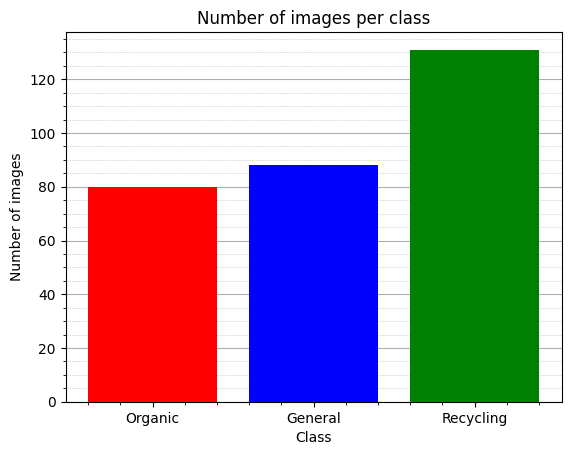

In [43]:
plt.bar(class_counts.keys(), class_counts.values(), color=[class2col[cls] for cls in class_counts.keys()], zorder=3)
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.minorticks_on()
plt.grid(axis="y", which="major")
plt.grid(axis="y", which="minor", linestyle=":", linewidth="0.5")
plt.title("Number of images per class")
plt.show()

### Camera Model Histogram

#### Code

In [44]:
patterns = ['/', '\\', '|', '-'] # Hopefully enough patterns for the number of models
model2pattern = {model: patterns[i] for i, model in enumerate(set(camera_models))}
#camera_model_set = set(camera_models)
camera_model_counts = {model: camera_models.count(model) for model in set(camera_models)}

#### Visualisation

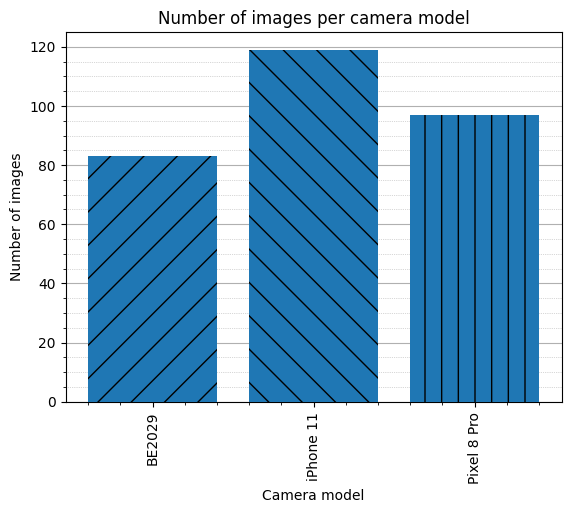

In [45]:
plt.bar(camera_model_counts.keys(), camera_model_counts.values(), hatch=[model2pattern[model] for model in camera_model_counts.keys()], zorder=3)
plt.xlabel("Camera model")
plt.ylabel("Number of images")
plt.minorticks_on()
plt.grid(axis="y", which="major")
plt.grid(axis="y", which="minor", linestyle=":", linewidth="0.5")
plt.title("Number of images per camera model")
plt.xticks(rotation=90)
plt.show()

### Class histogram split by camera model

#### Code

In [46]:
class_counts_per_model = {model: {cls: 0 for cls in set(classes)} for model in set(camera_models)}
for i, model in enumerate(camera_models):
    class_counts_per_model[model][classes[i]] += 1

#### Visualisation

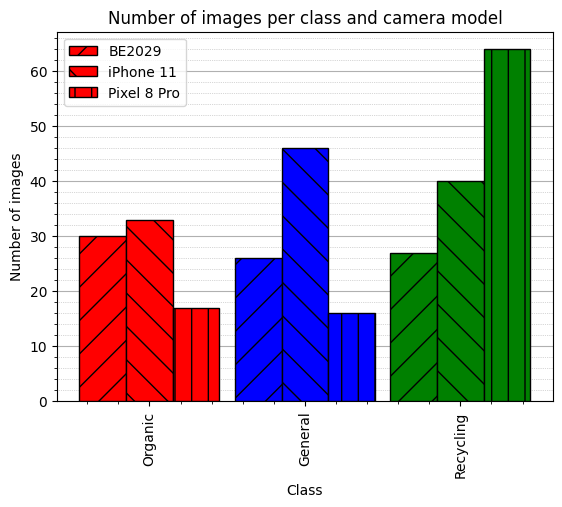

In [47]:
fig, ax = plt.subplots()
width = 0.3
x = range(len(class_counts_per_model[camera_models[0]]))
for i, model in enumerate(set(camera_models)):
    bar = ax.bar(
        [pos + i * width for pos in x],
        class_counts_per_model[model].values(),
        width,
        label=model,
        color=[class2col[cls] for cls in class_counts_per_model[model].keys()],
        hatch=model2pattern[model],
        edgecolor='black',
        zorder=3
    )

ax.set_xticks([pos + width for pos in x])
ax.set_xticklabels(class_counts_per_model[camera_models[0]].keys())
ax.legend()
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.minorticks_on()
plt.grid(axis="y", which="major")
plt.grid(axis="y", which="minor", linestyle=":", linewidth="0.5")
plt.title("Number of images per class and camera model")
plt.xticks(rotation=90)
plt.show()